All data loaded successfully.


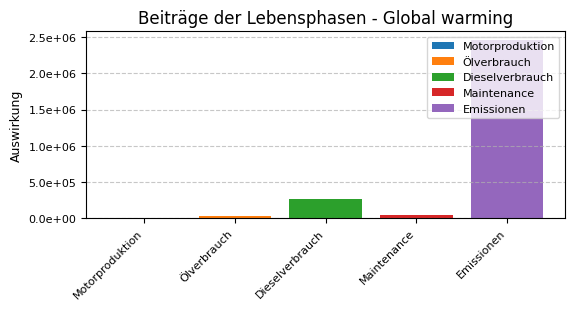

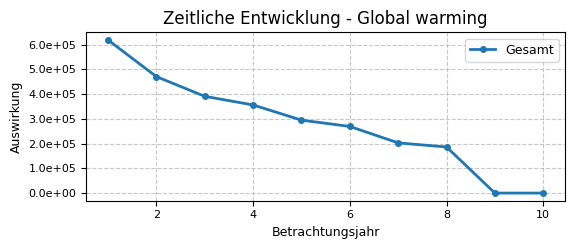

In [5]:
import tkinter
import customtkinter as ctk
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tkinter import ttk, messagebox
import numpy as np
from matplotlib import rcParams

# Schriftart für bessere Lesbarkeit in Diagrammen konfigurieren
rcParams['font.size'] = 9
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8

# --- Constants for Data URLs ---
URL_DUAL_FUEL_BACKGROUND = "https://raw.githubusercontent.com/Svenhardy/LoCaGas_App/main/Background_Data/CSV_Files/1.Dual_Fuel_Background_Data.csv"
URL_DUAL_FUEL_IMPACTS = "https://raw.githubusercontent.com/Svenhardy/LoCaGas_App/main/Background_Data/CSV_Files/2.Dual_Fuel_Impacts.csv"
URL_EMISSION_IMPACTS = "https://raw.githubusercontent.com/Svenhardy/LoCaGas_App/main/Background_Data/CSV_Files/3.Emission_Impacts.csv"
URL_ENGINE_DATA = "https://raw.githubusercontent.com/Svenhardy/LoCaGas_App/main/Background_Data/CSV_Files/4.Engine_Data.csv"
URL_ASSUMPTIONS = "https://raw.githubusercontent.com/Svenhardy/LoCaGas_App/main/Background_Data/CSV_Files/5.Assumptions.csv"
URL_EMISSIONS = "https://raw.githubusercontent.com/Svenhardy/LoCaGas_App/main/Background_Data/CSV_Files/6.Emission.csv"


class LoCaGasApp(ctk.CTk):
    def __init__(self):
        super().__init__()

        self.title("LoCaGas - Ökobilanz für Deponiegasverwertung")
        self.geometry("1400x900")
        ctk.set_appearance_mode("System")
        ctk.set_default_color_theme("blue")

        self.data_frames = {}
        self.results_data = {}
        self.manual_gas_entries = []
        self.manual_methane_entries = []

        # --- Main Layout ---
        self.grid_columnconfigure(0, weight=1)
        self.grid_rowconfigure(0, weight=1)

        self.tabview = ctk.CTkTabview(self)
        self.tabview.grid(row=0, column=0, padx=20, pady=20, sticky="nsew")
        self.tabview.add("Berechnung & Ergebnisse")
        self.tabview.add("Zwischenberechnungen")

        self.create_results_tab()
        self.create_intermediate_tab()

        self.load_data()

    def load_data(self):
        """Loads all necessary data from GitHub URLs into pandas DataFrames."""
        urls = {
            "dual_fuel_background": URL_DUAL_FUEL_BACKGROUND,
            "dual_fuel_impacts": URL_DUAL_FUEL_IMPACTS,
            "emission_impacts": URL_EMISSION_IMPACTS,
            "engine_data": URL_ENGINE_DATA,
            "assumptions": URL_ASSUMPTIONS,
            "emissions": URL_EMISSIONS,
        }
        try:
            for name, url in urls.items():
                response = requests.get(url)
                response.raise_for_status()

                if name in ["dual_fuel_impacts", "emission_impacts"]:
                    df = pd.read_csv(io.StringIO(response.text), sep=';', header=0, skiprows=[1])
                else:
                    df = pd.read_csv(io.StringIO(response.text), sep=';')

                df = df.dropna(axis=1, how='all').dropna(axis=0, how='all')
                df.columns = [col.strip() for col in df.columns]

                id_col = df.columns[0]
                # Strip whitespace from the ID column before setting as index
                if df[id_col].dtype == 'object':
                    df[id_col] = df[id_col].str.strip()

                for col in df.columns:
                    if col != id_col:
                        df[col] = pd.to_numeric(df[col], errors='coerce')

                df = df.dropna(subset=[col for col in df.columns if col != id_col], how='all')
                self.data_frames[name] = df.fillna(0)
            
            self.data_frames['assumptions'].set_index('Category', inplace=True)
            self.data_frames['dual_fuel_impacts'].set_index('Impact Category', inplace=True)
            self.data_frames['emission_impacts'].set_index('Category', inplace=True)

            self.update_impact_category_dropdown()
            print("All data loaded successfully.")

        except requests.exceptions.RequestException as e:
            messagebox.showerror("Fehler beim Laden der Daten", f"Daten konnten nicht von GitHub geladen werden.\nBitte überprüfen Sie Ihre Internetverbindung.\n\nError: {e}")
            self.destroy()
        except Exception as e:
            messagebox.showerror("Fehler bei der Datenverarbeitung", f"Ein Fehler ist bei der Verarbeitung der CSV-Daten aufgetreten.\nStellen Sie sicher, dass die Formatierung der online CSV-Dateien korrekt ist.\n\nError: {e}")
            self.destroy()

    def create_results_tab(self):
        """Creates the UI elements for the main results tab."""
        tab = self.tabview.tab("Berechnung & Ergebnisse")
        tab.grid_columnconfigure(0, weight=1)
        tab.grid_columnconfigure(1, weight=3)
        tab.grid_rowconfigure(0, weight=1)

        input_frame = ctk.CTkFrame(tab, width=400)  # Breiter gemacht für bessere Lesbarkeit
        input_frame.grid(row=0, column=0, padx=10, pady=10, sticky="nsew")
        input_frame.grid_propagate(False)
        
        # Überschrift mit mehr Platz
        title_label = ctk.CTkLabel(input_frame, text="Eingabeparameter", font=ctk.CTkFont(size=16, weight="bold"))
        title_label.pack(pady=(15, 20))  # Mehr vertikaler Platz

        ctk.CTkLabel(input_frame, text="Gasmenge zu Beginn [m³/h]").pack(pady=(10, 0))
        self.gas_menge_entry = ctk.CTkEntry(input_frame, placeholder_text="z.B. 500")
        self.gas_menge_entry.pack()
        self.gas_manual_check = ctk.CTkCheckBox(input_frame, text="Manuelle Eingabe", command=self.toggle_manual_gas)
        self.gas_manual_check.pack(pady=5)
        self.manual_gas_frame = ctk.CTkScrollableFrame(input_frame, label_text="Jährliche Gasmenge [m³/h]")
        
        ctk.CTkLabel(input_frame, text="Methangehalt zu Beginn [%]").pack(pady=(10, 0))
        self.methan_gehalt_entry = ctk.CTkEntry(input_frame, placeholder_text="z.B. 55")
        self.methan_gehalt_entry.pack()
        self.methan_manual_check = ctk.CTkCheckBox(input_frame, text="Manuelle Eingabe", command=self.toggle_manual_methane)
        self.methan_manual_check.pack(pady=5)
        self.manual_methane_frame = ctk.CTkScrollableFrame(input_frame, label_text="Jährlicher Methangehalt [%]")

        ctk.CTkLabel(input_frame, text="Betrachtungszeitraum [Jahre]").pack(pady=(10, 0))
        self.zeitraum_entry = ctk.CTkEntry(input_frame, placeholder_text="z.B. 10")
        self.zeitraum_entry.pack()
        self.zeitraum_entry.bind("<KeyRelease>", self.update_manual_fields_on_fly)

        self.calculate_button = ctk.CTkButton(input_frame, text="Berechnung starten", command=self.run_calculation)
        self.calculate_button.pack(pady=20, ipady=10)

        output_frame = ctk.CTkFrame(tab)
        output_frame.grid(row=0, column=1, padx=10, pady=10, sticky="nsew")
        output_frame.grid_columnconfigure(0, weight=1)
        output_frame.grid_rowconfigure(2, weight=1) 

        top_info_frame = ctk.CTkFrame(output_frame)
        top_info_frame.grid(row=0, column=0, columnspan=2, padx=10, pady=10, sticky="ew")
        
        # Frame für Motorinformation und Betriebsjahre
        info_container = ctk.CTkFrame(top_info_frame, fg_color="transparent")
        info_container.pack(fill="x", expand=True)
        
        self.selected_engine_label = ctk.CTkLabel(info_container, text="Ausgewählter Motor: -", font=ctk.CTkFont(size=14))
        self.selected_engine_label.pack(side="left", padx=10, pady=5)
        
        self.operational_years_label = ctk.CTkLabel(info_container, text="Betriebsjahre: -", font=ctk.CTkFont(size=14))
        self.operational_years_label.pack(side="left", padx=10, pady=5)

        # Dropdowns for chart control
        chart_controls_frame = ctk.CTkFrame(output_frame)
        chart_controls_frame.grid(row=1, column=0, columnspan=2, padx=10, pady=5, sticky="ew")
        
        # Linke Seite: Kontrolle für Balkendiagramm
        left_control_frame = ctk.CTkFrame(chart_controls_frame, fg_color="transparent")
        left_control_frame.pack(side="left", fill="x", expand=True)
        
        ctk.CTkLabel(left_control_frame, text="Wirkungskategorie für Balkendiagramm:", 
                    font=ctk.CTkFont(size=12)).pack(side="left", padx=(0, 10))
        
        self.impact_category_dropdown = ctk.CTkOptionMenu(left_control_frame, values=["-"], 
                                                         command=self.update_bar_chart)
        self.impact_category_dropdown.pack(side="left")
        
        # Rechte Seite: Kontrolle für Liniendiagramm
        right_control_frame = ctk.CTkFrame(chart_controls_frame, fg_color="transparent")
        right_control_frame.pack(side="right", fill="x", expand=True)
        
        ctk.CTkLabel(right_control_frame, text="Wirkungskategorie für Liniendiagramm:", 
                    font=ctk.CTkFont(size=12)).pack(side="left", padx=(0, 10))
        
        self.line_chart_impact_dropdown = ctk.CTkOptionMenu(right_control_frame, values=["-"], 
                                                           command=self.update_line_chart)
        self.line_chart_impact_dropdown.pack(side="left")
        
        ctk.CTkLabel(right_control_frame, text="Lebensphase:", 
                    font=ctk.CTkFont(size=12)).pack(side="left", padx=(20, 10))
        
        self.stage_dropdown = ctk.CTkOptionMenu(right_control_frame, values=["Gesamt"], 
                                               command=self.update_line_chart)
        self.stage_dropdown.pack(side="left")

        charts_frame = ctk.CTkFrame(output_frame)
        charts_frame.grid(row=2, column=0, columnspan=2, padx=10, pady=10, sticky="nsew")
        charts_frame.grid_columnconfigure(0, weight=1)
        charts_frame.grid_columnconfigure(1, weight=1)
        charts_frame.grid_rowconfigure(1, weight=1)
        
        # Add labels to charts
        ctk.CTkLabel(charts_frame, text="Beiträge der Lebensphasen", font=ctk.CTkFont(size=14, weight="bold")).grid(row=0, column=0, pady=(5,0))
        ctk.CTkLabel(charts_frame, text="Zeitliche Entwicklung der Auswirkungen", font=ctk.CTkFont(size=14, weight="bold")).grid(row=0, column=1, pady=(5,0))

        self.bar_chart_fig, self.bar_ax = plt.subplots(figsize=(7, 5))
        self.bar_chart_canvas = FigureCanvasTkAgg(self.bar_chart_fig, master=charts_frame)
        self.bar_chart_canvas.get_tk_widget().grid(row=1, column=0, padx=5, sticky="nsew")

        self.line_chart_fig, self.line_ax = plt.subplots(figsize=(7, 5))
        self.line_chart_canvas = FigureCanvasTkAgg(self.line_chart_fig, master=charts_frame)
        self.line_chart_canvas.get_tk_widget().grid(row=1, column=1, padx=5, sticky="nsew")

        # Results Table Frame (at the bottom)
        self.results_table_frame = ctk.CTkFrame(output_frame)
        self.results_table_frame.grid(row=3, column=0, columnspan=2, padx=10, pady=10, sticky="nsew")
        
        # Tabelle mit Lebensphasen-Auswahl
        table_controls_frame = ctk.CTkFrame(self.results_table_frame, fg_color="transparent")
        table_controls_frame.pack(fill="x", padx=10, pady=5)
        
        ctk.CTkLabel(table_controls_frame, text="Gesamtergebnisse nach Lebensphase:", 
                    font=ctk.CTkFont(size=14, weight="bold")).pack(side="left")
        
        ctk.CTkLabel(table_controls_frame, text="Lebensphase:", 
                    font=ctk.CTkFont(size=12)).pack(side="left", padx=(20, 10))
        
        self.table_stage_dropdown = ctk.CTkOptionMenu(table_controls_frame, values=["Gesamt"], 
                                                     command=self.display_total_results_table)
        self.table_stage_dropdown.pack(side="left")
        self.table_stage_dropdown.set("Gesamt")


    def create_intermediate_tab(self):
        """Creates the UI elements for the intermediate calculation results tab."""
        tab = self.tabview.tab("Zwischenberechnungen")
        tab.grid_columnconfigure(0, weight=1)
        tab.grid_rowconfigure(0, weight=1)
        tab.grid_rowconfigure(1, weight=1)
        
        yearly_frame = ctk.CTkFrame(tab)
        yearly_frame.grid(row=0, column=0, padx=10, pady=10, sticky="nsew")
        ctk.CTkLabel(yearly_frame, text="Jährliche Entwicklungen", font=ctk.CTkFont(size=14, weight="bold")).pack(pady=5)
        
        # Treeview für jährliche Entwicklungen
        tree_frame = ctk.CTkFrame(yearly_frame)
        tree_frame.pack(expand=True, fill="both", padx=10, pady=10)
        
        self.yearly_tree = ttk.Treeview(tree_frame)
        self.yearly_tree.pack(expand=True, fill="both")
        
        # Scrollbar für Treeview
        scrollbar = ttk.Scrollbar(tree_frame, orient="vertical", command=self.yearly_tree.yview)
        scrollbar.pack(side="right", fill="y")
        self.yearly_tree.configure(yscrollcommand=scrollbar.set)

        engine_frame = ctk.CTkFrame(tab)
        engine_frame.grid(row=1, column=0, padx=10, pady=10, sticky="nsew")
        ctk.CTkLabel(engine_frame, text="Motorauslastung im ersten Jahr", font=ctk.CTkFont(size=14, weight="bold")).pack(pady=5)
        
        # Treeview für Motorauslastung
        engine_tree_frame = ctk.CTkFrame(engine_frame)
        engine_tree_frame.pack(expand=True, fill="both", padx=10, pady=10)
        
        self.engine_tree = ttk.Treeview(engine_tree_frame)
        self.engine_tree.pack(expand=True, fill="both")
        
        # Scrollbar für Treeview
        engine_scrollbar = ttk.Scrollbar(engine_tree_frame, orient="vertical", command=self.engine_tree.yview)
        engine_scrollbar.pack(side="right", fill="y")
        self.engine_tree.configure(yscrollcommand=engine_scrollbar.set)

    def update_impact_category_dropdown(self):
        """Populates the dropdown with impact categories."""
        if 'dual_fuel_impacts' in self.data_frames:
            categories = self.data_frames['dual_fuel_impacts'].columns.tolist()
            self.impact_category_dropdown.configure(values=categories)
            self.line_chart_impact_dropdown.configure(values=categories)
            if "Global warming" in categories:
                self.impact_category_dropdown.set("Global warming")
                self.line_chart_impact_dropdown.set("Global warming")
            elif len(categories) > 0:
                self.impact_category_dropdown.set(categories[0])
                self.line_chart_impact_dropdown.set(categories[0])

    def _update_manual_fields(self, frame, entry_list):
        for widget in frame.winfo_children():
            widget.destroy()
        entry_list.clear()
        try:
            years = int(self.zeitraum_entry.get())
            if years > 50: years = 50
            for year in range(years):
                row_frame = ctk.CTkFrame(frame)
                row_frame.pack(fill="x", pady=2)
                ctk.CTkLabel(row_frame, text=f"Jahr {year + 1}:").pack(side="left", padx=5)
                entry = ctk.CTkEntry(row_frame)
                entry.pack(side="right", padx=5, expand=True, fill="x")
                entry_list.append(entry)
        except (ValueError, TypeError):
            pass

    def toggle_manual_gas(self):
        if self.gas_manual_check.get():
            self.manual_gas_frame.pack(pady=5, fill="x", expand=True)
            self._update_manual_fields(self.manual_gas_frame, self.manual_gas_entries)
        else:
            self.manual_gas_frame.pack_forget()

    def toggle_manual_methane(self):
        if self.methan_manual_check.get():
            self.manual_methane_frame.pack(pady=5, fill="x", expand=True)
            self._update_manual_fields(self.manual_methane_frame, self.manual_methane_entries)
        else:
            self.manual_methane_frame.pack_forget()
    
    def update_manual_fields_on_fly(self, event=None):
        if self.gas_manual_check.get():
             self._update_manual_fields(self.manual_gas_frame, self.manual_gas_entries)
        if self.methan_manual_check.get():
            self._update_manual_fields(self.manual_methane_frame, self.manual_methane_entries)

    def _validate_inputs(self):
        try:
            years = int(self.zeitraum_entry.get())
            if not 1 <= years <= 50: raise ValueError("Betrachtungszeitraum muss zwischen 1 und 50 Jahren liegen.")
            if not self.gas_manual_check.get(): float(self.gas_menge_entry.get())
            else:
                if len(self.manual_gas_entries) != years: raise ValueError("Bitte füllen Sie alle manuellen Gas-Felder aus.")
                for entry in self.manual_gas_entries: float(entry.get())
            if not self.methan_manual_check.get():
                methan = float(self.methan_gehalt_entry.get())
                if not 0 <= methan <= 100: raise ValueError("Methangehalt muss zwischen 0 und 100% liegen.")
            else:
                if len(self.manual_methane_entries) != years: raise ValueError("Bitte füllen Sie alle manuellen Methan-Felder aus.")
                for entry in self.manual_methane_entries:
                    methan = float(entry.get())
                    if not 0 <= methan <= 100: raise ValueError("Methangehalt muss zwischen 0 und 100% liegen.")
            return True
        except (ValueError, TypeError) as e:
            messagebox.showerror("Ungültige Eingabe", f"Bitte überprüfen Sie Ihre Eingabewerte.\n\nDetails: {e}")
            return False

    def run_calculation(self):
        if not self._validate_inputs(): return
        
        zeitraum = int(self.zeitraum_entry.get())
        gas_profile = self._get_gas_profile(zeitraum)
        if gas_profile is None: return

        engine_load_check, best_engine = self._select_best_engine(gas_profile.iloc[0])
        self.display_intermediate_engine_load(engine_load_check)
        if best_engine is None:
            messagebox.showerror("Kein passender Motor", "Für die eingegebenen Startwerte konnte kein geeigneter Motor gefunden werden (Auslastung > 100% für alle Größen).")
            return
        self.selected_engine_label.configure(text=f"Ausgewählter Motor: {best_engine['Engine Size [kWel]']} kWel")

        yearly_results, intermediate_yearly_data = self._calculate_yearly_impacts(gas_profile, best_engine)
        if yearly_results is None: return
        
        self.results_data['yearly_impacts'] = yearly_results
        self.results_data['total_impacts'] = {stage: df.sum() for stage, df in yearly_results.items()}
        
        # Betriebsjahre berechnen (Jahre mit Status "In Betrieb")
        operational_years = len(intermediate_yearly_data[intermediate_yearly_data['Status'] == 'In Betrieb'])
        self.operational_years_label.configure(text=f"Betriebsjahre: {operational_years}")
        
        self.display_intermediate_yearly_data(intermediate_yearly_data)
        
        # Dropdown für Lebensphasen in der Tabelle aktualisieren
        stages = ["Gesamt"] + list(self.results_data['yearly_impacts'].keys())
        self.table_stage_dropdown.configure(values=stages)
        self.table_stage_dropdown.set("Gesamt")
        
        # Dropdown für Liniendiagramm aktualisieren
        self.stage_dropdown.configure(values=stages)
        self.stage_dropdown.set("Gesamt")
        
        self.display_total_results_table("Gesamt")
        self.update_bar_chart()
        self.update_line_chart()

    def _get_gas_profile(self, zeitraum):
        df_data = []
        try:
            if self.gas_manual_check.get(): gas_values = [float(e.get()) for e in self.manual_gas_entries]
            else: gas_values = [float(self.gas_menge_entry.get()) * (0.9**i) for i in range(zeitraum)]
            
            if self.methan_manual_check.get(): methane_values = [float(e.get()) for e in self.manual_methane_entries]
            else: methane_values = [float(self.methan_gehalt_entry.get()) * (0.9**i) for i in range(zeitraum)]

            for i in range(zeitraum):
                df_data.append({'Jahr': i + 1, 'Gasmenge': gas_values[i], 'Methangehalt': methane_values[i]})
        except (ValueError, IndexError):
            messagebox.showerror("Fehler bei manueller Eingabe", "Bitte füllen Sie alle manuellen Felder für den gewählten Zeitraum mit gültigen Zahlen.")
            return None
        return pd.DataFrame(df_data)

    def _calculate_engine_load(self, year_data, engine_data):
        assumptions = self.data_frames['assumptions']['Value']
        methan_anteil = year_data['Methangehalt'] / 100.0
        gas_energy = (year_data['Gasmenge'] * methan_anteil) * assumptions['Calorific Value CH4 [kWh/m^3]']
        diesel_energy = engine_data['Diesel Consumption [L/h]'] * assumptions['Calorific Value Diesel [kW/L]']
        power_output = (gas_energy + diesel_energy) * (engine_data['Engine efficency'] / 100.0)
        return (power_output / engine_data['Engine Size [kWel]']) * 100.0

    def _select_best_engine(self, year_1_data):
        engines, load_results, valid_engines = self.data_frames['engine_data'], [], []
        for _, engine in engines.iterrows():
            load = self._calculate_engine_load(year_1_data, engine)
            load_results.append({'Motorgröße [kWel]': engine['Engine Size [kWel]'], 'Auslastung Jahr 1 [%]': load})
            if load <= 100:
                engine_with_load = engine.copy()
                engine_with_load['load_diff'] = 100 - load
                valid_engines.append(engine_with_load)
        if not valid_engines: return pd.DataFrame(load_results), None
        best_engine = sorted(valid_engines, key=lambda x: x['load_diff'])[0]
        return pd.DataFrame(load_results), best_engine.drop('load_diff')

    def _find_closest_row(self, df, col, val):
        return df.iloc[(df[col] - val).abs().argsort()[:1]]

    def _calculate_yearly_impacts(self, gas_profile, engine):
        assumptions = self.data_frames['assumptions']['Value']
        annual_runtime = assumptions['Annual runtime [h]']
        impact_categories = self.data_frames['dual_fuel_impacts'].columns
        
        yearly_impacts = {
            'Motorproduktion': pd.DataFrame(0.0, index=gas_profile['Jahr'], columns=impact_categories),
            'Ölverbrauch': pd.DataFrame(0.0, index=gas_profile['Jahr'], columns=impact_categories),
            'Dieselverbrauch': pd.DataFrame(0.0, index=gas_profile['Jahr'], columns=impact_categories),
            'Maintenance': pd.DataFrame(0.0, index=gas_profile['Jahr'], columns=impact_categories),
            'Emissionen': pd.DataFrame(0.0, index=gas_profile['Jahr'], columns=impact_categories),
        }
        intermediate_data = []

        # Motorproduktion (einmalig im ersten Jahr)
        prod_factor = engine['Production Factor']
        prod_impacts = self.data_frames['dual_fuel_impacts'].loc['Engine Production']
        yearly_impacts['Motorproduktion'].loc[1] = prod_factor * prod_impacts

        for _, year_data in gas_profile.iterrows():
            year = int(year_data['Jahr'])
            engine_load = self._calculate_engine_load(year_data, engine)
            
            if year == 1:
                if not (engine['Min. volume flow [m^3/h]'] <= year_data['Gasmenge'] <= engine['Max. volume flow [m^3/h]']):
                    messagebox.showerror("Fehler", f"In Jahr 1 liegt die Gasmenge ({year_data['Gasmenge']:.1f} m³/h) außerhalb des Bereichs ({engine['Min. volume flow [m^3/h]']}-{engine['Max. volume flow [m^3/h]']} m³/h).")
                    return None, None
                if engine_load < engine['Minimum Engine Load']:
                    messagebox.showerror("Fehler", f"In Jahr 1 liegt die Motorauslastung ({engine_load:.1f}%) unter dem Minimum von {engine['Minimum Engine Load']}%.")
                    return None, None
            
            if not (engine['Min. volume flow [m^3/h]'] <= year_data['Gasmenge'] <= engine['Max. volume flow [m^3/h]']) or engine_load < engine['Minimum Engine Load']:
                intermediate_data.append({'Jahr': year, 'Gasmenge': year_data['Gasmenge'], 'Methangehalt': year_data['Methangehalt'], 'Motorauslastung [%]': engine_load, 'Status': 'Außer Betrieb'})
                continue
            
            intermediate_data.append({'Jahr': year, 'Gasmenge': year_data['Gasmenge'], 'Methangehalt': year_data['Methangehalt'], 'Motorauslastung [%]': engine_load, 'Status': 'In Betrieb'})

            # Ölverbrauch
            background_data = self.data_frames['dual_fuel_background']
            oil_change_h = self._find_closest_row(background_data, 'Engine Load[%]', engine_load)['Oil change [opr. h]'].iloc[0]
            yearly_oil_L = (annual_runtime / oil_change_h) * engine['Oil tank volume']
            yearly_impacts['Ölverbrauch'].loc[year] = yearly_oil_L * self.data_frames['dual_fuel_impacts'].loc['Operating Resources [1L oil]']

            # Dieselverbrauch
            yearly_diesel_L = engine['Diesel Consumption [L/h]'] * annual_runtime
            yearly_impacts['Dieselverbrauch'].loc[year] = yearly_diesel_L * self.data_frames['dual_fuel_impacts'].loc['Fuel Consumption [1L Diesel]']

            # Maintenance
            maint_h = self._find_closest_row(background_data, 'Engine Load[%]', engine_load)['Maintenance Period [opr. h]'].iloc[0]
            maint_factor = annual_runtime / maint_h
            yearly_impacts['Maintenance'].loc[year] = maint_factor * self.data_frames['dual_fuel_impacts'].loc['Maintenance [filter production]']

            # Emissionen
            emission_rates_row = self._find_closest_row(self.data_frames['emissions'], 'Engine Range [% of Load]', engine_load)
            total_gas_volume_year = year_data['Gasmenge'] * annual_runtime
            
            total_emission_impacts_year = pd.Series(0.0, index=impact_categories)
            
            # Mapping between emission types in emissions.csv and impact categories in emission_impacts.csv
            emission_mapping = {
                'CO': 'CO Organic',
                'NOx': 'Nox',
                'Formldehyd': 'Formaldehyd',
                'CH4 slop': 'CH4',
                'Particulate Matter': 'Fine particulate matter formation'
            }
            
            for emission_col, impact_category in emission_mapping.items():
                if emission_col in emission_rates_row.columns and impact_category in self.data_frames['emission_impacts'].index:
                    emission_rate = emission_rates_row[emission_col].iloc[0]
                    total_emission = emission_rate * total_gas_volume_year
                    impact_values = self.data_frames['emission_impacts'].loc[impact_category]
                    total_emission_impacts_year += total_emission * impact_values
            
            yearly_impacts['Emissionen'].loc[year] = total_emission_impacts_year

        return yearly_impacts, pd.DataFrame(intermediate_data)

    def display_total_results_table(self, stage_filter):
        for widget in self.results_table_frame.winfo_children():
            if not isinstance(widget, (ctk.CTkFrame, ctk.CTkLabel, ctk.CTkOptionMenu)):
                widget.destroy()
                
        if not self.results_data or 'total_impacts' not in self.results_data: 
            return
        
        # Erstelle DataFrame basierend auf der ausgewählten Lebensphase
        if stage_filter == "Gesamt":
            total_impacts = pd.DataFrame(self.results_data['total_impacts']).sum(axis=1)
        else:
            total_impacts = self.results_data['total_impacts'][stage_filter]

        total_impacts_df = pd.DataFrame({'Wirkungskategorie': total_impacts.index, 'Gesamtwert': total_impacts.values})
        
        # Treeview für Ergebnisse
        tree_frame = ctk.CTkFrame(self.results_table_frame)
        tree_frame.pack(expand=True, fill="both", padx=10, pady=10)
        
        tree = ttk.Treeview(tree_frame, columns=list(total_impacts_df.columns), show='headings')
        
        for col in total_impacts_df.columns:
            tree.heading(col, text=col)
            tree.column(col, width=250, anchor='w')
        
        for _, row in total_impacts_df.iterrows():
            tree.insert('', 'end', values=[row['Wirkungskategorie'], f"{row['Gesamtwert']:.2e}"])
        
        # Scrollbar hinzufügen
        scrollbar = ttk.Scrollbar(tree_frame, orient="vertical", command=tree.yview)
        scrollbar.pack(side="right", fill="y")
        tree.configure(yscrollcommand=scrollbar.set)
        
        tree.pack(expand=True, fill="both")

    def display_intermediate_yearly_data(self, df):
        for item in self.yearly_tree.get_children(): 
            self.yearly_tree.delete(item)
            
        self.yearly_tree["column"] = list(df.columns)
        self.yearly_tree["show"] = "headings"
        
        for col in df.columns: 
            self.yearly_tree.heading(col, text=col)
            self.yearly_tree.column(col, width=100)
            
        for _, row in df.iterrows(): 
            self.yearly_tree.insert("", "end", values=[f"{v:.2f}" if isinstance(v, (int, float)) else v for v in row])
    
    def display_intermediate_engine_load(self, df):
        for item in self.engine_tree.get_children(): 
            self.engine_tree.delete(item)
            
        self.engine_tree["column"] = list(df.columns)
        self.engine_tree["show"] = "headings"
        
        for col in df.columns: 
            self.engine_tree.heading(col, text=col)
            self.engine_tree.column(col, width=150)
            
        for _, row in df.iterrows(): 
            self.engine_tree.insert("", "end", values=[f"{v:.2f}" if isinstance(v, (int, float)) else v for v in row])
    
    def update_bar_chart(self, _=None):
        if not self.results_data or 'total_impacts' not in self.results_data: 
            return
            
        impact_category = self.impact_category_dropdown.get()
        
        # Update bar chart
        self.bar_ax.clear()
        
        # Farben für die Lebensphasen
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
        
        bar_data = {stage: impacts[impact_category] for stage, impacts in self.results_data['total_impacts'].items()}
        
        bars = self.bar_ax.bar(range(len(bar_data)), list(bar_data.values()), color=colors[:len(bar_data)])
        self.bar_ax.set_ylabel('Auswirkung')
        self.bar_ax.set_title(f'Beiträge der Lebensphasen - {impact_category}', fontsize=12)
        
        # X-Achse mit Lebensphasen beschriften
        self.bar_ax.set_xticks(range(len(bar_data)))
        self.bar_ax.set_xticklabels(list(bar_data.keys()), rotation=45, ha='right')
        
        self.bar_ax.grid(axis='y', linestyle='--', alpha=0.7)
        self.bar_ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(x, '.1e')))
        
        # Legende hinzufügen
        legend_labels = list(bar_data.keys())
        self.bar_ax.legend(bars, legend_labels, loc='upper right', fontsize=8)
        
        self.bar_chart_fig.tight_layout()
        self.bar_chart_canvas.draw()

    def update_line_chart(self, _=None):
        if not self.results_data or 'yearly_impacts' not in self.results_data: 
            return
            
        impact_category = self.line_chart_impact_dropdown.get()
        stage_filter = self.stage_dropdown.get()
        
        # Update line chart
        self.line_ax.clear()
        
        if stage_filter == "Gesamt":
            total_yearly = sum(df[impact_category] for df in self.results_data['yearly_impacts'].values())
            self.line_ax.plot(total_yearly.index, total_yearly.values, label="Gesamt", marker='o', markersize=4, linewidth=2)
        else:
            yearly_df = self.results_data['yearly_impacts'][stage_filter]
            self.line_ax.plot(yearly_df.index, yearly_df[impact_category], label=stage_filter, marker='o', markersize=4, linewidth=2)

        self.line_ax.set_title(f'Zeitliche Entwicklung - {impact_category}', fontsize=12)
        self.line_ax.set_xlabel('Betrachtungsjahr')
        self.line_ax.set_ylabel('Auswirkung')
        self.line_ax.legend(fontsize=9)
        self.line_ax.grid(True, linestyle='--', alpha=0.7)
        self.line_ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(x, '.1e')))
        
        self.line_chart_fig.tight_layout()
        self.line_chart_canvas.draw()


if __name__ == "__main__":
    app = LoCaGasApp()
    app.mainloop()